# Sensores Phybox

## Datos adquiridos

Para la realización del ejercicio se recogen datos de:
* Subir escaleras
* Bajar escaleras
* Caminar
* Correr
* Estar quieto en el metro

Conocemos que, poniendo el móvil sobre la mesa:
* El eje x es el que va de izquierda a derecha
* El eje y es el que va de delante a detrás
* El eje z es el que va de arriba a abajo
* Además, el acelerómetro mide la aceleración en m/s^2

In [9]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import get_window#, rfft, rfftfreq

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [10]:
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

### 1. Carga de datos

In [11]:
# Solo aceleración en los tres ejes, absoluta no
def carga_df(filename, etiqueta):
    df = pd.read_csv(os.path.join('data', filename)).iloc[:, :4]
    df['etiqueta'] = etiqueta
    df.columns = ['time', 'x', 'y', 'z', 'etiqueta']
    return df

In [12]:
df_bajar1 = carga_df('bajar_escaleras_1.csv', 'bajar_escaleras')
df_bajar2 = carga_df('bajar_escaleras_2.csv', 'bajar_escaleras')
df_subir = carga_df('subir_escaleras.csv', 'subir_escaleras')
df_bajar1_metro = carga_df('enelmetro.csv', 'metro')

In [13]:
df_bajar1.shape

(5638, 5)

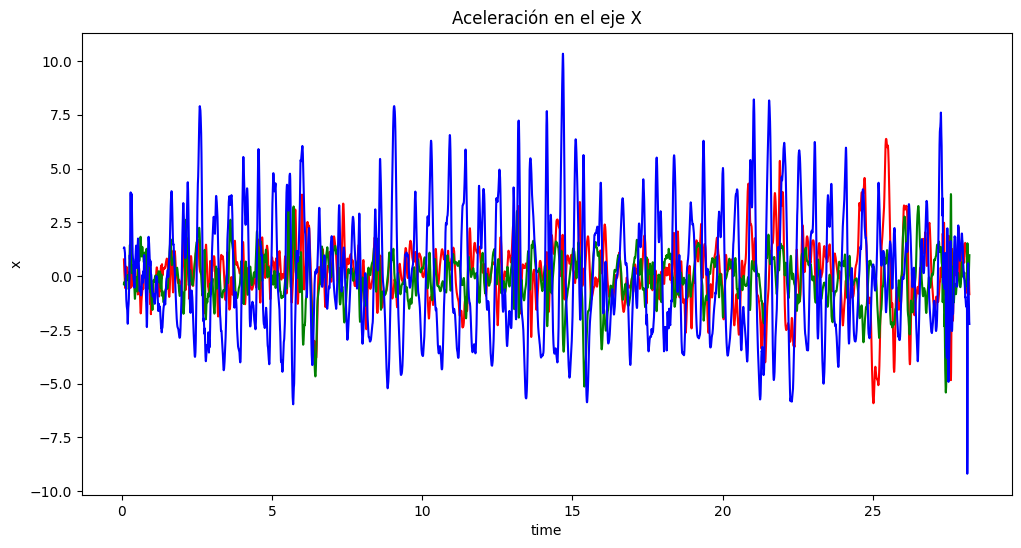

In [14]:
# Visualizar los datos
setup_graph(title='Aceleración en el eje X', x_label='time', y_label='x', fig_size=(12, 6))
plt.plot(df_bajar1['time'], df_bajar1['x'], color='r')
plt.plot(df_bajar1['time'], df_bajar1['y'], color='g')
plt.plot(df_bajar1['time'], df_bajar1['z'], color='b')
plt.show()

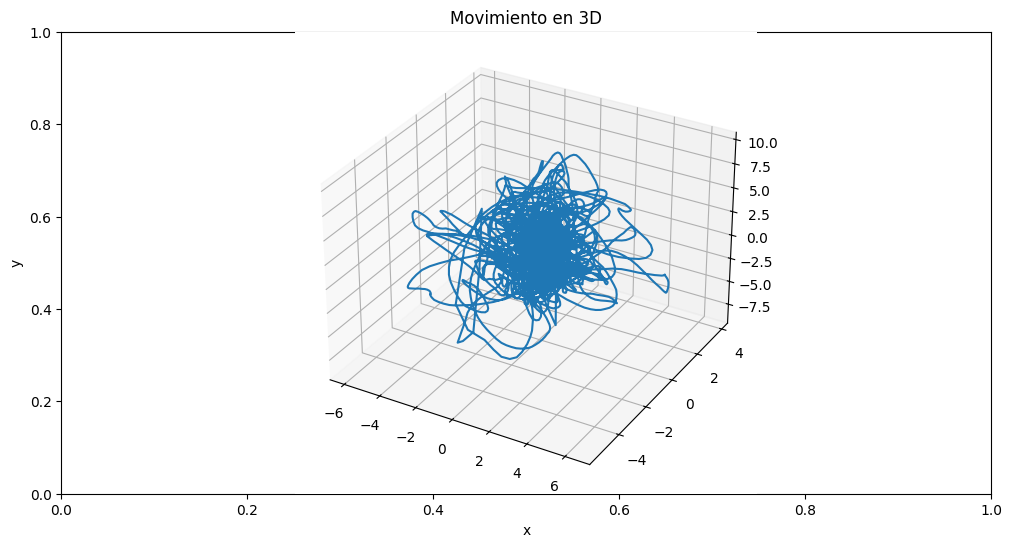

In [15]:
# Recreación del movimiento en 3D
from mpl_toolkits.mplot3d import Axes3D

setup_graph(title='Movimiento en 3D', x_label='x', y_label='y', fig_size=(12, 6))
ax = plt.subplot(111, projection='3d')
ax.plot(df_bajar1['x'], df_bajar1['y'], df_bajar1['z'])
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 

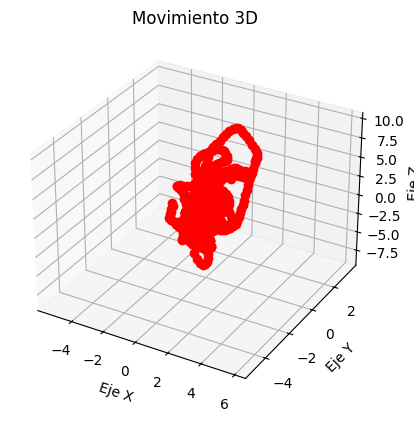

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Configuración inicial para la figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Configurar los límites del gráfico según tus datos
ax.set_xlim([df_bajar1['x'].min(), df_bajar1['x'].max()])
ax.set_ylim([df_bajar1['y'].min(), df_bajar1['y'].max()])
ax.set_zlim([df_bajar1['z'].min(), df_bajar1['z'].max()])

# Titulo y etiquetas
ax.set_title('Movimiento 3D')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Función de inicialización: plota el fondo de cada cuadro
def init():
    ax.plot(df_bajar1['x'][0:1], df_bajar1['y'][0:1], df_bajar1['z'][0:1], 'ro')
    return fig,

# Función de animación: se llama secuencialmente
def animate(i):
    ax.plot(df_bajar1['x'][i:i+1], df_bajar1['y'][i:i+1], df_bajar1['z'][i:i+1], 'ro')
    return fig,

# Llamar al animador, blit=True significa que solo se redibuja lo que ha cambiado
ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(df_bajar1), interval=20000, blit=True)

# Guardar la animación
ani.save('movimiento_3d.gif', writer='imagemagick', fps=60)

In [ ]:
asdadasd

## Metodología

### 2. Obtener características con una ventana móvil que se va solapando: en el dominio del tiempo

In [ ]:
# Cada ventana tendrá 1000 puntos, y el dataframe para clasificar contendrá una fila por ventana y una columna por característica extraída, además de la etiqueta

#### - Dominio del tiempo

In [ ]:
# Dominio del tiempo: max, min, std, kurtosis...
def freq_features(raw_df, window_size=1000, step_size=200):
    data = []
    for i in range(0, len(raw_df)-window_size, step_size):
        window = raw_df[i:i+window_size]
        features = {}
        for axis in ['x', 'y', 'z']:
            features[f'{axis}_min'] = window[axis].min()
            features[f'{axis}_max'] = window[axis].max()
            features[f'{axis}_median'] = window[axis].median()
            features[f'{axis}_mean'] = window[axis].mean()
            features[f'{axis}_std'] = window[axis].std()
            features[f'{axis}_skewness'] = window[axis].skew()
            features[f'{axis}_kurtosis'] = window[axis].kurtosis()
            features[f'{axis}_iqr'] = window[axis].quantile(0.75) - window[axis].quantile(0.25)
            features[f'{axis}_entropy'] = -np.sum(window[axis] * np.log(window[axis]))
            features[f'{axis}_mad'] = window[axis].mad()
            features[f'{axis}_rms'] = np.sqrt(np.mean(window[axis]**2))          
        features['etiqueta'] = window['etiqueta'].iloc[0]
        data.append(features)
    
    # Generar nombres de columnas basados en las claves del primer elemento de 'data'
    columns = list(data[0].keys())
    return pd.DataFrame(data, columns=columns)

In [ ]:
(5600-1000)/200 # (n_puntos-ventana_size)/step_size = n_ventanas --> hacer un esquemita

23.0

In [ ]:
df_bajar1_features = freq_features(df_bajar1)
df_bajar2_features = freq_features(df_bajar2)
df_subir_features = freq_features(df_subir)
df_metro_features = freq_features(df_metro)

# Concatenar los dataframes
df_caracts_tiempo_1 = pd.concat([df_bajar1_features, df_bajar2_features, df_subir_features, df_metro_features], ignore_index=True)

### 3. Clasificador 1: RF, xgboost, SVM, catboost

In [ ]:
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass')
X = df_caracts_tiempo_1.iloc[:, :-1]
y = df_caracts_tiempo_1['etiqueta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
accuracy_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

0:	learn: 1.0499970	total: 170ms	remaining: 2m 49s
1:	learn: 1.0091876	total: 173ms	remaining: 1m 26s
2:	learn: 0.9324063	total: 175ms	remaining: 58.1s
3:	learn: 0.8836722	total: 177ms	remaining: 44.1s
4:	learn: 0.8317218	total: 181ms	remaining: 35.9s
5:	learn: 0.7821508	total: 183ms	remaining: 30.4s
6:	learn: 0.7479407	total: 187ms	remaining: 26.6s
7:	learn: 0.7139859	total: 190ms	remaining: 23.6s
8:	learn: 0.6696043	total: 193ms	remaining: 21.2s
9:	learn: 0.6461929	total: 195ms	remaining: 19.3s
10:	learn: 0.6152263	total: 198ms	remaining: 17.8s
11:	learn: 0.5943064	total: 199ms	remaining: 16.4s
12:	learn: 0.5617910	total: 202ms	remaining: 15.4s
13:	learn: 0.5378660	total: 205ms	remaining: 14.4s
14:	learn: 0.5140367	total: 207ms	remaining: 13.6s
15:	learn: 0.4910762	total: 210ms	remaining: 12.9s
16:	learn: 0.4706082	total: 211ms	remaining: 12.2s
17:	learn: 0.4451429	total: 214ms	remaining: 11.7s
18:	learn: 0.4280292	total: 217ms	remaining: 11.2s
19:	learn: 0.4147830	total: 219ms	remai

array([[11,  0,  0],
       [ 0,  3,  0],
       [ 0,  0,  1]], dtype=int64)

### 4. Fourier

Para esta sección, desarrollaremos una función que calcule la potencia espectral total y la frecuencia dominante para cada eje. La potencia espectral total se puede calcular como la suma del cuadrado de las magnitudes de la FFT normalizada por la longitud de la ventana, mientras que la frecuencia dominante es simplemente la frecuencia con la máxima magnitud en el espectro.

* Frecuencia dominante: El componente de frecuencia con mayor potencia en la señal. Indica el componente de frecuencia más significativo presente en la señal.
* Potencia espectral total: La potencia total de la señal, que representa la fuerza o energía global de la señal en todos los componentes de frecuencia.
𝑃𝑆𝐷 = ∑𝑆(𝑓𝑘)

In [ ]:
# Dominio de la frecuencia (puede que se obtengan mejores resultados) --> MyFFT y de la transformada saco las características
def myFTT(Fs, X):
    window = get_window('hann', len(X), fftbins=True)
    X = X * window
    fft_out = np.fft.rfft(X)
    fft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
    num_samples = len(X)
    rfreqs = [(i*1.0/num_samples)*Fs for i in range(num_samples//2+1)]
    return rfreqs, fft_mag

In [ ]:
# Kurtosis espectral
# Frecuencia dominante y potencia espectral de cada uno de los ejes
# Potencia espectral total: sumatorio de magnitudes obtenidas con Fourier en cada ventana de las definidas

def calculate_fft_features(window, fs=100):
    """
    Calcula la FFT de una ventana de datos y extrae la frecuencia dominante y la potencia espectral total.

    Parámetros:
    - window: DataFrame de Pandas que contiene los datos de la ventana.
    - fs: Frecuencia de muestreo.

    Retorna:
    - Un diccionario con las características calculadas.
    """
    features = {}
    window_length = len(window)

    for axis in ['x', 'y', 'z']:
        # Aplicar ventana de Hann para suavizar los extremos de la ventana
        hann_window = get_window("hann", window_length)
        windowed_signal = window[axis] * hann_window

        # Calcular la FFT
        fft_vals = np.abs(rfft(windowed_signal))

        # Frecuencias correspondientes a los valores de la FFT
        freqs = rfftfreq(window_length, 1/fs)

        # - Potencia espectral total
        power_spec_total = np.sum(fft_vals**2) / len(fft_vals)

        # - Frecuencia dominante
        dominant_freq = freqs[np.argmax(fft_vals)]

        # Almacenar las características
        features[f'{axis}_dominant_freq'] = dominant_freq
        features[f'{axis}_power_spec_total'] = power_spec_total

    return features


all_features = []
window_size = 1000  # Puede necesitar ajustes
step_size = 200  # Puede necesitar ajustes

for start in range(0, len(df_bajar1) - window_size + 1, step_size):
    end = start + window_size
    window_df = df_bajar1.iloc[start:end]
    features = calculate_fft_features(window_df, fs=100)  # Ajustar fs si es necesario
    all_features.append(features)

features_df = pd.DataFrame(all_features)

**Aplicación de la FFT**

Al aplicar la FFT a las señales de aceleración, transformamos los datos del dominio del tiempo al dominio de la frecuencia. Esto nos permite identificar las frecuencias dominantes en la señal, que corresponden a los movimientos más repetitivos o destacados durante la actividad medida. La rfft se utiliza en lugar de fft para optimizar el cálculo dado que nuestras señales son reales y no complejas.

**Parámetros Importantes**
* **Frecuencia de Muestreo (fs)**: Este parámetro determina cuán frecuentemente se recogen muestras de la señal. Afecta directamente a la resolución de nuestra FFT y a la frecuencia máxima que podemos analizar correctamente (frecuencia de Nyquist). En nuestro contexto, debe coincidir con la frecuencia de muestreo de los datos del acelerómetro.
* **Número de Muestras (num_samples)**: Afecta a la resolución de las frecuencias que podemos analizar. Cuantas más muestras tengamos, más detallada será nuestra FFT, permitiéndonos identificar frecuencias más específicas.

**Interpretación de Resultados**
* **Frecuencia Dominante**: Esta es la frecuencia con la mayor amplitud en nuestra FFT. Indica el ritmo principal de la actividad, como el paso mientras se camina o corre. Al extraer esta característica, podemos diferenciar entre diferentes tipos de actividades basadas en su ritmo o frecuencia de movimiento predominante.
* **Potencia Espectral Total**: Representa la suma de las potencias de todas las frecuencias presentes en la señal. Nos da una idea de la "energía" total del movimiento, lo que puede ayudar a distinguir entre movimientos rápidos y energéticos frente a movimientos lentos y suaves.

### 5. Clasificador 2 con las nuevas características (mantener mismos modelos para poder comparar resultados)

Implementaremos clasificadores similares a los de la Actividad 3, pero esta vez utilizando las características extraídas del dominio de la frecuencia. Compararemos el rendimiento de los modelos en esta configuración con los resultados anteriores para ver si las características de frecuencia proporcionan una mejor distinción entre las actividades.

In [ ]:
# Preparar los datos para el entrenamiento del modelo
X = features_df.drop('etiqueta', axis=1)
y = df_bajar1['etiqueta'].iloc[::step_size][0:len(features_df)].reset_index(drop=True)  # Asegúrate de alinear las etiquetas correctamente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Entrenar el modelo. Aquí se usa RandomForest como ejemplo, pero puedes usar cualquier clasificador.
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', verbose=False)
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

¿Cual, o cuales son las características que más información proveen en el dominio temporal? ¿Y en el frecuencial? demuéstralo representándolo gráficamente

Entrenamiento del Modelo y Extracción de la Importancia de Características

In [ ]:
# Entrenar un modelo para el dominio temporal
X_temporal = df_caracts_tiempo_1.drop('etiqueta', axis=1)
y_temporal = df_caracts_tiempo_1['etiqueta']
model_temporal = RandomForestClassifier(n_estimators=100, random_state=42)
model_temporal.fit(X_temporal, y_temporal)


# Entrenar un modelo para el dominio frecuencial
X_frecuencial = features_df.drop('etiqueta', axis=1)
y_frecuencial = features_df['etiqueta']
model_frecuencial = RandomForestClassifier(n_estimators=100, random_state=42)
model_frecuencial.fit(X_frecuencial, y_frecuencial)

Visualización de la Importancia de Características

In [ ]:
# Visualización para el dominio temporal
features_temporal = X_temporal.columns
importances_temporal = model_temporal.feature_importances_
indices_temporal = np.argsort(importances_temporal)

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características - Dominio Temporal')
plt.barh(range(len(indices_temporal)), importances_temporal[indices_temporal], color='b', align='center')
plt.yticks(range(len(indices_temporal)), [features_temporal[i] for i in indices_temporal])
plt.xlabel('Importancia Relativa')
plt.show()


# Visualización para el dominio frecuencial
features_frecuencial = X_frecuencial.columns
importances_frecuencial = model_frecuencial.feature_importances_
indices_frecuencial = np.argsort(importances_frecuencial)

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características - Dominio Frecuencial')
plt.barh(range(len(indices_frecuencial)), importances_frecuencial[indices_frecuencial], color='r', align='center')
plt.yticks(range(len(indices_frecuencial)), [features_frecuencial[i] for i in indices_frecuencial])
plt.xlabel('Importancia Relativa')
plt.show()

Estos gráficos muestran qué características son las más relevantes para los modelos en cada dominio, proporcionando una respuesta visual a cuáles son más informativas. Este enfoque no solo ayuda a entender qué características son más útiles para la clasificación, sino que también puede guiar la ingeniería de características futura y la selección de características para mejorar los modelos de clasificación.

## Resultados

### 6. La más importante, comparar resultados, explicar modelos creados e interpretar características en ambos dominios

Aquí, visualizaremos y compararemos los resultados obtenidos en las Actividades 3 y 5. Podemos utilizar gráficos como el ROC-AUC para los diferentes modelos o gráficos de barras comparando la precisión de cada modelo en ambos dominios (temporal y frecuencial). Esta visualización ayudará a identificar qué características y qué dominio proporcionan una mejor clasificación de las actividades.

Cálculo de Métricas y Curvas ROC para Cada Modelo

In [ ]:
from scipy import interp
from itertools import cycle

# Esta función asume una clasificación binaria o multiclase. Para multiclase, las etiquetas deben estar binarizadas.
def plot_roc_curve(y_test, y_score, n_classes, title='Curva ROC'):
    # Binarizar las etiquetas en un formato one-vs-all
    y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])
    
    # Calcular ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

Visualización de la Precisión de los Modelos

In [ ]:
precisions = [0.95, 0.92, 0.96, 0.93, 0.89, 0.90, 0.97, 0.94]  # Reemplaza estos valores con las precisiones reales de tus modelos

In [ ]:
precisions = {
    'Modelo': ['RF Temporal', 'RF Frecuencial', 'XGB Temporal', 'XGB Frecuencial', 'SVM Temporal', 'SVM Frecuencial', 'CatBoost Temporal', 'CatBoost Frecuencial'],
    'Precisión': precisions
}

df_precisions = pd.DataFrame(precisions)

plt.figure(figsize=(10, 6))
sns.barplot(x='Precisión', y='Modelo', data=df_precisions)
plt.title('Comparación de la Precisión de Modelos en Dominios Temporal y Frecuencial')
plt.xlabel('Precisión')
plt.ylabel('Modelo')
plt.xlim(0, 1)
plt.show()

### 7. Conclusiones y líneas futuras

* a
* b
* c

Presentación: 2 mins cada apartado/persona, 5-10 total